In [2]:
import sklearn
import tensorflow as tf
import open3d as o3d
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
import matplotlib.pyplot as plt
import numpy as np
import alphashape
import cv2
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
import os

2022-07-25 15:49:24.559810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2022-07-25 15:49:24.559826: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
files = ['Data/unprocessed/training/' + file for file in os.listdir('Data/unprocessed/training')]
dataset = tf.data.TFRecordDataset(files, buffer_size=int(pow(10,6)), num_parallel_reads=16)
for data in dataset:
   frame = open_dataset.Frame()
   frame.ParseFromString(bytearray(data.numpy()))
   image = frame.images[0]
   image = np.array(tf.io.decode_jpeg(image.image))

   if np.mean(image) < 100:
      continue

   (range_images, camera_projections, _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)
   points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
   points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
      frame,
      range_images,
      camera_projections,
      range_image_top_pose,
      ri_index=1)
   # 3d points in vehicle frame.
   points_all = np.concatenate(points, axis=0)
   points_all_ri2 = np.concatenate(points_ri2, axis=0)
   # camera projection corresponding to each point.
   cp_points_all = np.concatenate(cp_points, axis=0)
   cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)
   
   all_points = np.append(points_all, points_all_ri2, axis=0)
   all_points_cp = np.append(cp_points_all, cp_points_all_ri2, axis=0)

   front_points = np.array([point for (point, cp) in zip(all_points, all_points_cp) if cp[0] == 1 or cp[3] == 1])
   front_cp_points = np.array([cp[:3] if cp[0] == 1 else cp[3:] for cp in all_points_cp if cp[0] == 1 or cp[3] == 1])

   pcd = o3d.geometry.PointCloud()
   pcd.points = o3d.utility.Vector3dVector(front_points)
   plane_model, inliers = pcd.segment_plane(distance_threshold=0.1, ransac_n=4, num_iterations=1000)
   inlier_cloud = pcd.select_by_index(inliers)
   outlier_cloud = pcd.select_by_index(inliers, invert=True)
   inlier_cloud.paint_uniform_color([1, 0, 0])
   outlier_cloud.paint_uniform_color([0.6, 0.6, 0.6])

   # o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

   front_cp_points_no_road = np.delete(front_cp_points, inliers, axis=0)

   alpha_shape = alphashape.alphashape(front_cp_points_no_road[:,1:3], 0.02)
   int_coords = lambda x: np.array(x).round().astype(np.int32)

   try:
      exteriors = [int_coords(poly.exterior.coords) for poly in alpha_shape]
   except:
      exteriors = [int_coords(poly.exterior.coords) for poly in [alpha_shape]]

   mask = np.zeros(image.shape[:2], dtype="uint8")

   fig, ax = plt.subplots()
   ax.scatter(*zip(*front_cp_points_no_road[:,1:3]))
   ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
   plt.show()

   cv2.fillPoly(mask, exteriors, 1)
   plt.imshow(image, cmap='gray')
   plt.show()
   image = cv2.bitwise_and(image, image, mask=mask)
   plt.imshow(image, cmap='gray')
   plt.show()
   key = input()
   if key == 'x':
      break 

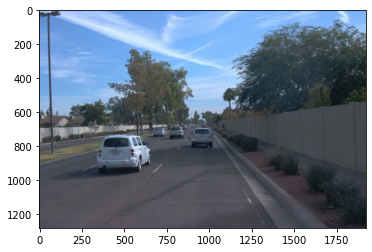

In [4]:
files = ['Data/unprocessed/training/' + file for file in os.listdir('Data/unprocessed/training')]
dataset = tf.data.TFRecordDataset(files, buffer_size=int(pow(10,6)), num_parallel_reads=16)
for data in dataset.skip(2):
   frame = open_dataset.Frame()
   frame.ParseFromString(bytearray(data.numpy()))
   image = frame.images[0]
   image = np.array(tf.io.decode_jpeg(image.image))
   plt.imshow(image, cmap='gray')
   plt.show()
   key = input()
   if key == 'x':
      break 

In [ ]:
# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

all_points = np.append(points_all, points_all_ri2, axis=0)
all_points_cp = np.append(cp_points_all, cp_points_all_ri2, axis=0)

front_points = np.array([point for (point, cp) in zip(all_points, all_points_cp) if cp[0] == 1])
front_cp_points = np.array([cp for cp in all_points_cp if cp[0] == 1])

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(front_points)
plane_model, inliers = pcd.segment_plane(distance_threshold=0.2, ransac_n=4, num_iterations=1000)
inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)
inlier_cloud.paint_uniform_color([1, 0, 0])
outlier_cloud.paint_uniform_color([0.6, 0.6, 0.6])

front_cp_points_no_road = np.delete(front_cp_points, inliers, axis=0)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])


In [ ]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c
  
def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[1])  # width, col
    ys.append(point[2])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

In [ ]:
plot_points_on_image(front_cp_points_no_road, image, rgba, point_size=5.0)

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from descartes import PolygonPatch
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.dirname(os.getcwd()))
import alphashape
import cv2

alpha_shape = alphashape.alphashape(front_cp_points_no_road[:,1:3], 0.0001)
fig, ax = plt.subplots()
ax.scatter(*zip(*front_cp_points_no_road[:,1:3]))
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))



In [ ]:
cam_image = np.array(tf.io.decode_jpeg(image.image))
int_coords = lambda x: np.array(x).round().astype(np.int32)
exteriors = [int_coords(poly.exterior.coords) for poly in alpha_shape]
mask = np.zeros(cam_image.shape[:2], dtype="uint8")
print(mask.shape)
cv2.fillPoly(mask, exteriors, 1)
cam_image = cv2.bitwise_and(cam_image, cam_image, mask=mask)
plt.imshow(cam_image, cmap="gray")